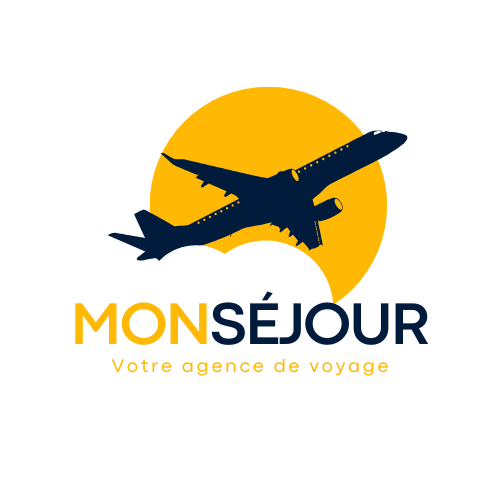

# 📑 I. Analyse et Conception de l'Application

## 1. Identification des Besoins
L'application **MonSéjour.fr** répond à deux niveaux de besoins identifiés pour les voyageurs :
* **Besoins Communs :** Accès à la météo locale, localisation des hébergements, identification des réseaux de transport et points d'intérêt culturels.
* **Besoins Spécifiques :** Personnalisation de l'expérience selon le **profil utilisateur** (Budget max, régimes alimentaires spécifiques comme Vegan ou Halal, et type d'activités).

## 2. Qualification des Sources de Données
Nous avons sélectionné des sources de données variées pour garantir la fiabilité de l'information :

| Catégorie | Source | Format | Type de Collecte |
| :--- | :--- | :--- | :--- |
| **Météo** | Open-Meteo API | JSON | API REST |
| **Hébergement** | OpenDataSoft (OSM) | JSON | API REST |
| **Restauration** | Guide Michelin | HTML | **Web Scraping** |
| **Transports** | WFS MEL / ODS | GeoJSON | API & Flux Temps Réel |
| **Culture** | Data.Culture.gouv | JSON | API REST |

## 3. Architecture Orientée Objet
L'application est conçue selon un paradigme **POO** pour assurer la modularité et la maintenabilité.



### Structure des classes :
* **Classe `Collecte` :** Moteur technique gérant les requêtes HTTP, le scraping et les appels API.
* **Classes Items (`Hotel`, `Restaurant`, `Transport`, `Météo`, `Loisir`) :** Modélisation des données brutes en objets Python.
* **Classes Gestionnaires (`Hotels`, `Restaurants`, etc.) :** Responsables du stockage temporaire, du filtrage par budget/régime et de l'exportation CSV.
* **Classe `Voyage` :** Orchestrateur liant le profil utilisateur aux données collectées.

## 4. Stockage et Traitement
Les données sont collectées dynamiquement puis **stockées localement au format CSV**. Ce choix technique permet :
1.  De constituer un historique de consultation.
2.  D'optimiser les performances du Notebook en évitant des appels réseaux redondants.
3.  De faciliter le traitement des données avec la bibliothèque **Pandas**.

# 🚀 II. Implémentation et Restitution Dynamique des Données

Dans cette partie, nous simulons la requête d'un utilisateur souhaitant organiser un séjour. 
L'application traite la demande en temps réel, filtre les bases de données et génère un rapport complet par catégorie.

In [2]:
!pip install folium pandas matplotlib requests beautifulsoup4 ipywidgets

In [1]:
import sys
import os
import importlib
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt

# 1. Configuration des chemins
sys.path.append(os.getcwd())
DOSSIER_DATA = r"C:\Users\Adam\Documents\Université\wahil\nb\SAE Collecte auto de données web\SAE\data"

# 2. Importation du moteur codeSAE
try:
    import codeSAE
    # Force le rechargement si tu modifies le fichier .py
    importlib.reload(codeSAE)
    
    # Importation des classes spécifiques pour un usage direct
    from codeSAE import Voyage, Profil, Collecte, Interface
    print("✅ Moteur codeSAE.py et classe Interface chargés avec succès !")
except ImportError:
    print("❌ Erreur : Impossible de trouver codeSAE.py dans le dossier courant.")
except Exception as e:
    print(f"❌ Erreur lors du chargement du module : {e}")

# 3. Vérification du dossier Data
if not os.path.exists(DOSSIER_DATA):
    os.makedirs(DOSSIER_DATA)
    print(f"📁 Dossier data créé à l'emplacement : {DOSSIER_DATA}")

✅ Moteur codeSAE.py et classe Interface chargés avec succès !


# Choix du profil

In [2]:
# --- ÉTAPE 1 : CONFIGURATION DU SÉJOUR (VERSION ALLÉGÉE) ---

# 1. Création des widgets
ville_selector = widgets.Dropdown(
    options=["Lille", "Roubaix", "Tourcoing", "Villeneuve-d'ascq"], 
    value="Lille", 
    description='📍 Ville :'
)
nb_personnes_slider = widgets.IntSlider(
    value=2, min=1, max=6, 
    description='👥 Voyageurs:'
)
out_profil = widgets.Output()

def actualiser_tout(change):
    global v, p  # Mise à jour des objets pour tout le notebook
    with out_profil:
        clear_output(wait=True)
        print(f"⏳ Préparation du séjour à {ville_selector.value}...")
        
        # On délègue la création du profil et du voyage au Backend
        p, v = Interface.preparer_sejour(ville_selector.value, nb_personnes_slider.value)
        
        clear_output(wait=True)
        # Affichage du petit tableau de bord de succès
        Interface.afficher_bilan_synchro(v)

# 2. Liaison des widgets
ville_selector.observe(actualiser_tout, names='value')
nb_personnes_slider.observe(actualiser_tout, names='value')

# 3. Affichage
display(widgets.VBox([
    widgets.HTML("<h2>⚙️ Configuration du séjour</h2>"), 
    ville_selector, 
    nb_personnes_slider, 
    out_profil
]))

# Lancement initial automatique
actualiser_tout(None)

## Choix de l'hôtel

In [3]:
# Chargement de la base complète des hôtels
df_h = pd.read_csv(f"{DOSSIER_DATA}/hotels_{v.ville}.csv", sep=';')

# Création du menu déroulant avec les noms des hôtels
hotel_selector = widgets.Dropdown(
    options=df_h['Nom'].tolist(),
    description='🏨 Choisir :',
    style={'description_width': 'initial'}
)

print("Sélectionnez l'hôtel qui vous intéresse pour voir les détails :")
display(hotel_selector)

Sélectionnez l'hôtel qui vous intéresse pour voir les détails :


Dropdown(description='🏨 Choisir :', options=('Hôtel Saint-Maurice', 'Hôtel Casino Barrière Lille', 'Villa Aram…

In [5]:
def afficher_fiche_hotel(change):
    clear_output(wait=True)
    display(hotel_selector)
    
    # On appelle la classe Interface de ton fichier codeSAE.py
    # pour générer le HTML complexe
    html_fiche = codeSAE.Interface.fiche_hotel_html(hotel_selector.value, df_h, v.ville)
    
    display(HTML(html_fiche))

hotel_selector.observe(afficher_fiche_hotel, names='value')
afficher_fiche_hotel(None)

Dropdown(description='🏨 Choisir :', index=1, options=('Hôtel Saint-Maurice', 'Hôtel Casino Barrière Lille', 'V…

## ☁️ État du Ciel et Climatologie en Temps Réel

In [6]:
# On récupère les données météo de l'objet voyage
def afficher_meteo(voyage):
    m = voyage.meteo_m.donnees
    
    print(f"📍 DESTINATION : {voyage.ville}")
    print(f"🌡️ TEMPÉRATURE : {m.temp}°C")
    print(f"☁️ CONDITIONS  : {m.desc}")

# Pour l'afficher joliment dans le Notebook
afficher_meteo(v)

📍 DESTINATION : Lille
🌡️ TEMPÉRATURE : 5.2°C
☁️ CONDITIONS  : Perturbé


## 🎨 Suggestion Culturelle

In [7]:
# --- ÉTAPE 4 : SUGGESTION CULTURELLE (SÉCURISÉE) ---

# 1. Vérification de sécurité : on regarde si la liste n'est pas vide
if v.l_m.liste_objets:
    # On prend le premier loisir trouvé
    loisir = v.l_m.liste_objets[0]
    
    print(f"🎨 Nous vous suggérons une activité culturelle : {loisir.nom}")
    
    # 2. Création de la carte Folium
    carte_loisir = folium.Map(location=[loisir.lat, loisir.lon], zoom_start=15)
    
    # Ajout du marqueur
    folium.Marker(
        [loisir.lat, loisir.lon], 
        popup=loisir.nom,
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(carte_loisir)
    
    display(carte_loisir)
else:
    # Cas où l'API n'a rien renvoyé (ex: petite ville ou erreur réseau)
    loisir = None
    print("⚠️ Aucun loisir culturel n'a été trouvé pour cette destination.")
    print("💡 Vous pouvez continuer à explorer les restaurants et transports.")

🎨 Nous vous suggérons une activité culturelle : Le Prato
théâtre International de Quartier 
pôle National Cirque - Lille


## 🚇 Comment s'y rendre ?

In [8]:
# --- ÉTAPE 4b : TRAJET VERS L'ACTIVITÉ CULTURELLE ---

out_trajet_loisir = widgets.Output()

def calculer_trajet_vers_loisir(change=None):
    with out_trajet_loisir:
        clear_output(wait=True)
        # On vérifie que l'hôtel est choisi et que le loisir existe
        if hotel_selector.value and (v.l_m.liste_objets):
            # On récupère l'activité suggérée plus haut
            activite = v.l_m.liste_objets[0]
            h_info = df_h[df_h['Nom'] == hotel_selector.value].iloc[0]
            
            # Calcul des stations via le backend
            st_dep, st_arr = Interface.trouver_stations_proches(
                v, h_info['Lat'], h_info['Lon'], activite.lat, activite.lon
            )
            
            if st_dep is not None:
                print(f"🚇 Trajet Culturel : {st_dep['Nom']} ➔ {st_arr['Nom']}")
                m = Interface.generer_carte_trajet(
                    h_info['Lat'], h_info['Lon'], activite.lat, activite.lon, 
                    st_dep, st_arr, activite.nom
                )
                display(m)

# On réagit si l'utilisateur change d'hôtel
hotel_selector.observe(calculer_trajet_vers_loisir, names='value')

display(widgets.VBox([widgets.Label(value="🚇 VOTRE TRAJET VERS L'ACTIVITÉ :"), out_trajet_loisir]))
calculer_trajet_vers_loisir()

## 🍴 Choix du restaurant

In [9]:
# --- ÉTAPE 5 : RECHERCHE ET FILTRAGE DES RESTAURANTS (VERSION ALLÉGÉE) ---

# 1. Configuration des widgets
options_regime = ['Omnivore', 'Végétarien', 'Vegan', 'Halal', 'Sans Gluten']
regime_input = widgets.Dropdown(options=options_regime, value=v.profil.regime, description='Régime :')
cuisine_input = widgets.Text(description='Style :', placeholder='Ex: Pizza, Sushi...')
prix_max_slider = widgets.IntSlider(value=40, min=10, max=150, description='Prix Max (€):')

# Sélecteur pour l'étape suivante
resto_selector = widgets.Dropdown(description='🎯 MON CHOIX :', style={'description_width': 'initial'})
out_resto_liste = widgets.Output()

def filtrer_restaurants(change=None):
    with out_resto_liste:
        clear_output(wait=True)
        # On délègue le filtrage complexe à la classe Interface dans codeSAE.py
        resultats = Interface.obtenir_restaurants_filtres(
            v.ville, regime_input.value, cuisine_input.value, prix_max_slider.value
        )
        
        if not resultats.empty:
            resto_selector.options = resultats['Nom'].tolist()
            print(f"✅ {len(resultats)} restaurants trouvés :")
            display(resultats[['Nom', 'Cuisine', 'Prix']])
        else:
            resto_selector.options = []
            print("❌ Aucun restaurant trouvé.")

# 2. Liaison des widgets et affichage
for w in [regime_input, cuisine_input, prix_max_slider]:
    w.observe(filtrer_restaurants, names='value')

display(widgets.VBox([
    widgets.Label(value="1️⃣ FILTREZ VOS PRÉFÉRENCES :"),
    widgets.HBox([regime_input, cuisine_input]),
    prix_max_slider,
    out_resto_liste
]))

filtrer_restaurants() # Lancement initial

In [12]:
# --- ÉTAPE 6 : SÉLECTION FINALE ET CARTE ---

out_carte_resto = widgets.Output()

def afficher_carte_resto(change):
    if not resto_selector.value:
        return
    with out_carte_resto:
        clear_output(wait=True)
        # On recharge pour avoir les coordonnées
        df_r = pd.read_csv(f"{DOSSIER_DATA}/restaurants_{v.ville}.csv", sep=';')
        resto_info = df_r[df_r['Nom'] == resto_selector.value].iloc[0]
        
        r_lat, r_lon = float(resto_info['Lat']), float(resto_info['Lon'])
        m_resto = folium.Map(location=[r_lat, r_lon], zoom_start=16)
        folium.Marker(
            [r_lat, r_lon], 
            popup=resto_selector.value,
            icon=folium.Icon(color='orange', icon='cutlery', prefix='fa')
        ).add_to(m_resto)
        display(m_resto)

# Liaison du sélecteur (créé en cellule 1) à la carte
resto_selector.observe(afficher_carte_resto, names='value')

display(widgets.VBox([
    widgets.Label(value="2️⃣ CHOISISSEZ VOTRE RESTAURANT PARMI LA LISTE :"),
    resto_selector,
    out_carte_resto
]))

# On force l'affichage si un resto est déjà sélectionné
if resto_selector.value:
    afficher_carte_resto(None)

## 🚇 Optimisation des Flux de Déplacement (Réseau de Transport Ilévia)

In [13]:
# --- ÉTAPE 7 : OPTIMISATION DES FLUX  ---

out_itineraire = widgets.Output()

def calculer_trajet_ilevia(change=None):
    with out_itineraire:
        clear_output(wait=True)
        if not resto_selector.value:
            print("⏳ En attente du restaurant...")
            return

        # 1. Données
        h_info = df_h[df_h['Nom'] == hotel_selector.value].iloc[0]
        df_r = pd.read_csv(f"{DOSSIER_DATA}/restaurants_{v.ville}.csv", sep=';')
        r_info = df_r[df_r['Nom'] == resto_selector.value].iloc[0]

        # 2. Appel Backend (Stations + Carte)
        st_dep, st_arr = Interface.trouver_stations_proches(v, h_info['Lat'], h_info['Lon'], r_info['Lat'], r_info['Lon'])
        
        if st_dep is not None:
            print(f"✅ Itinéraire optimisé : Embarquez à {st_dep['Nom']} et descendez à {st_arr['Nom']}")
            m = Interface.generer_carte_trajet(h_info['Lat'], h_info['Lon'], r_info['Lat'], r_info['Lon'], st_dep, st_arr, r_info['Nom'])
            display(m)

# Liaison
resto_selector.observe(calculer_trajet_ilevia, names='value')
display(widgets.VBox([widgets.Label(value="🚇 VOTRE TRAJET VIA LE RÉSEAU ILÉVIA :"), out_itineraire]))
calculer_trajet_ilevia()

## 💰 Estimation du Budget Total

In [14]:
# --- ÉTAPE FINALE : ESTIMATION DU BUDGET TOTAL (VERSION SÉCURISÉE) ---

out_budget = widgets.Output()

def afficher_bilan_budget(change=None):
    with out_budget:
        clear_output(wait=True)
        
        try:
            # SÉCURITÉ : On recharge les DataFrames ici pour éviter le NameError
            df_h_budget = pd.read_csv(f"{DOSSIER_DATA}/hotels_{v.ville}.csv", sep=';')
            df_r_budget = pd.read_csv(f"{DOSSIER_DATA}/restaurants_{v.ville}.csv", sep=';')
            
            # Appel au backend
            Interface.afficher_recap_complet_budget(
                hotel_selector.value, 
                resto_selector.value, 
                nb_personnes_slider.value, 
                p.budget_max, 
                df_h_budget, 
                df_r_budget
            )
        except Exception as e:
            print("⏳ En attente de la sélection complète de l'hôtel et du restaurant...")

# Liaison et affichage
for w in [hotel_selector, resto_selector, nb_personnes_slider]:
    w.observe(afficher_bilan_budget, names='value')

display(widgets.VBox([widgets.Label(value="💰 BILAN FINANCIER :"), out_budget]))
afficher_bilan_budget()

## 📝 Synthèse Globale et Génération du Carnet de Route Numérique

In [15]:
# --- DERNIÈRE ÉTAPE : VOTRE CARNET DE ROUTE NUMÉRIQUE ---

out_recap = widgets.Output()

def generer_recapitulatif(change=None):
    with out_recap:
        clear_output(wait=True)
        
        # Sécurité : on vérifie si un loisir a été trouvé à l'étape culturelle
        nom_loisir = loisir.nom if 'loisir' in locals() and loisir else "Découverte libre"
        
        # On appelle la mise en forme décorée du Backend
        recap = Interface.generer_recap_texte(
            v, 
            hotel_selector.value, 
            resto_selector.value, 
            nom_loisir
        )
        print(recap)

# Liaison avec les sélecteurs pour une mise à jour en temps réel
hotel_selector.observe(generer_recapitulatif, names='value')
resto_selector.observe(generer_recapitulatif, names='value')
nb_personnes_slider.observe(generer_recapitulatif, names='value')

display(widgets.Label(value="📝 RÉCAPITULATIF DE VOTRE CARNET DE ROUTE :"))
display(out_recap)

# Lancement initial
generer_recapitulatif()

Label(value='📝 RÉCAPITULATIF DE VOTRE CARNET DE ROUTE :')

Output()

# 🏁 III. Conclusion et Perspectives
L'application MonSéjour.fr démontre la puissance de Python pour transformer des flux de données bruts et disparates en un service d'aide à la décision personnalisé et interactif.

### 🎯 1. Objectifs Atteints
Interopérabilité technique : Nous avons réussi à faire communiquer des sources de données hétérogènes, incluant le Web Scraping (Guide Michelin), les flux WFS en temps réel (MEL/Ilévia) et des APIs REST (Open-Meteo, OpenDataSoft).

Architecture Modulaire : L'approche par Programmation Orientée Objet (POO) a permis de structurer le code en classes distinctes, garantissant une maintenance aisée et une synchronisation parfaite des données entre le moteur (codeSAE.py) et l'interface (Notebook).

Interface Dynamique : L'intégration des ipywidgets offre une expérience utilisateur fluide, permettant d'ajuster le budget, les transports et les activités instantanément selon le profil choisi.

### 🚀 2. Perspectives d'Évolution
Le projet pose les bases d'un outil plus vaste qui pourrait intégrer :

Extension Géographique : L'ajout de nouvelles métropoles en adaptant simplement les filtres de collecte de la classe Collecte.

Intelligence de Recommandation : Un filtrage encore plus fin croisant les préférences du profil avec des analyses de sentiments issues d'avis clients scrapés.

Exportation Nomade : Une fonctionnalité permettant de générer un PDF du "Carnet de Route" pour une consultation hors ligne.

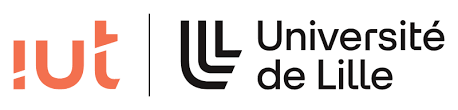